In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import preprocess as pp
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses a GPU!')
else:
    device = torch.device('cpu')
    print('The code uses a CPU...')

The code uses a CPU...


In [3]:
task = 'regression'
dataset = 'AP_tetra_fd'
radius = 1
(dataset_train, dataset_dev, dataset_test,
     N_fingerprints) = pp.create_datasets(task, dataset, radius, device)

data_train.txt
data_test.txt


In [5]:
print('# of training data samples:', len(dataset_train))
print('# of development data samples:', len(dataset_dev))
print('# of test data samples:', len(dataset_test))

dim=50
layer_hidden=6
layer_output=6
batch_train=32
batch_test=32

# of training data samples: 143929
# of development data samples: 15993
# of test data samples: 159922


In [4]:
class MolecularGraphNeuralNetwork(nn.Module):
    def __init__(self, N_fingerprints, dim, layer_hidden, layer_output):
        super(MolecularGraphNeuralNetwork, self).__init__()
        self.embed_fingerprint = nn.Embedding(N_fingerprints, dim)
        self.W_fingerprint = nn.ModuleList([nn.Linear(dim, dim)
                                            for _ in range(layer_hidden)])
        self.W_output = nn.ModuleList([nn.Linear(dim, dim)
                                       for _ in range(layer_output)])
        if task == 'classification':
            self.W_property = nn.Linear(dim, 2)
        if task == 'regression':
            self.W_property = nn.Linear(dim, 1)

    def pad(self, matrices, pad_value):
        """Pad the list of matrices
        with a pad_value (e.g., 0) for batch processing.
        For example, given a list of matrices [A, B, C],
        we obtain a new matrix [A00, 0B0, 00C],
        where 0 is the zero (i.e., pad value) matrix.
        """
        shapes = [m.shape for m in matrices]
        M, N = sum([s[0] for s in shapes]), sum([s[1] for s in shapes])
        zeros = torch.FloatTensor(np.zeros((M, N))).to(device)
        pad_matrices = pad_value + zeros
        i, j = 0, 0
        for k, matrix in enumerate(matrices):
            m, n = shapes[k]
            pad_matrices[i:i+m, j:j+n] = matrix
            i += m
            j += n
        return pad_matrices

    def update(self, matrix, vectors, layer):
        hidden_vectors = torch.relu(self.W_fingerprint[layer](vectors))
        return hidden_vectors + torch.matmul(matrix, hidden_vectors)

    def sum(self, vectors, axis):
        sum_vectors = [torch.sum(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(sum_vectors)

    def mean(self, vectors, axis):
        mean_vectors = [torch.mean(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(mean_vectors)

    def gnn(self, inputs):

        """Cat or pad each input data for batch processing."""
        fingerprints, adjacencies, molecular_sizes = inputs
        fingerprints = torch.cat(fingerprints)
        adjacencies = self.pad(adjacencies, 0)

        """GNN layer (update the fingerprint vectors)."""
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        for l in range(layer_hidden):
            hs = self.update(adjacencies, fingerprint_vectors, l)
            fingerprint_vectors = F.normalize(hs, 2, 1)  # normalize.

        """Molecular vector by sum or mean of the fingerprint vectors."""
        molecular_vectors = self.sum(fingerprint_vectors, molecular_sizes)
        # molecular_vectors = self.mean(fingerprint_vectors, molecular_sizes)

        return molecular_vectors

    def mlp(self, vectors):
        """Classifier or regressor based on multilayer perceptron."""
        for l in range(layer_output):
            vectors = torch.relu(self.W_output[l](vectors))
        outputs = self.W_property(vectors)
        return outputs

    def forward_classifier(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_labels = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_scores = self.mlp(molecular_vectors)
            loss = F.cross_entropy(predicted_scores, correct_labels)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_scores = self.mlp(molecular_vectors)
            predicted_scores = predicted_scores.to('cpu').data.numpy()
            predicted_scores = [s[1] for s in predicted_scores]
            correct_labels = correct_labels.to('cpu').data.numpy()
            return predicted_scores, correct_labels

    def forward_regressor(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_values = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_values = self.mlp(molecular_vectors)
            loss = F.mse_loss(predicted_values, correct_values)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_values = self.mlp(molecular_vectors)
            predicted_values = predicted_values.to('cpu').data.numpy()
            correct_values = correct_values.to('cpu').data.numpy()
            molecular_vectors = molecular_vectors.to('cpu').data.numpy()
            predicted_values = np.concatenate(predicted_values)
            correct_values = np.concatenate(correct_values)
            molecular_vectors = np.concatenate(molecular_vectors)
            return predicted_values, correct_values

In [6]:
torch.manual_seed(1234)
model = MolecularGraphNeuralNetwork(
        38, dim, layer_hidden, layer_output).to(device)

print('# of model parameters:',
      sum([np.prod(p.size()) for p in model.parameters()]))

# of model parameters: 32551


In [13]:
model.load_state_dict(torch.load('BestModel_ub_tetra.pt'))
model.eval()

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_81054/454797347.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('BestModel_ub

MolecularGraphNeuralNetwork(
  (embed_fingerprint): Embedding(38, 50)
  (W_fingerprint): ModuleList(
    (0-5): 6 x Linear(in_features=50, out_features=50, bias=True)
  )
  (W_output): ModuleList(
    (0-5): 6 x Linear(in_features=50, out_features=50, bias=True)
  )
  (W_property): Linear(in_features=50, out_features=1, bias=True)
)

In [14]:
N = len(dataset_test)
D = []
V = []
for i in range(0, N, batch_test):
    data_batch = list(zip(*dataset_test[i:i+batch_test]))
    predicted_scores, correct_scores = model.forward_regressor(
                                       data_batch, train=False)
    D.append(np.abs(predicted_scores-correct_scores))

In [15]:
diff = []
for i in range(len(D)):
    for j in range(len(D[i])):
        diff.append(D[i][j])

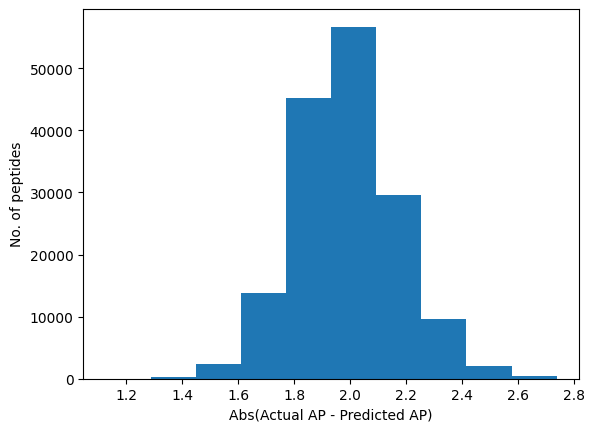

In [16]:
plt.hist(diff)
plt.xlabel('Abs(Actual AP - Predicted AP)')
plt.ylabel('No. of peptides')
plt.show() 

In [17]:
len(diff)

159922

In [46]:
max(diff)

2.737873

In [19]:
len(dataset_test)

159922

In [26]:
pep = pd.read_csv('../dataset/regression/AP_tetra_fd/tetra_slc_fd.txt', sep=' ')
pep

,Pep,AP
0,AAAA,0
1,AAAR,0
2,AAAN,0
3,AAAD,0
4,AAAC,0
...,...,...
159995,VVVS,0
159996,VVVT,0
159997,VVVW,0
159998,VVVY,0


In [40]:
for i in range(len(diff)):
    pep['AP'].iloc[i]=diff[i]

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_81054/4169824128.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pep['AP'].iloc[i]=diff[i]
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_81054/4169824128.py:2: Setti

In [52]:
pep.to_csv('../dataset/regression/AP_tetra_fd/fd_pred.csv')

In [47]:
# Step 1: Create bins of size 0.2 for the 'AP' column
bin_size = 0.2
pep['bins'] = pd.cut(pep['AP'], bins=np.arange(pep['AP'].min(), pep['AP'].max() + bin_size, bin_size))

# Step 2: Determine the number of bins and peptides per bin
total_peptides = 3000
unique_bins = pep['bins'].nunique()
peptides_per_bin = total_peptides // unique_bins

# Step 3: Sample equal number of peptides from each bin
sampled_pep = pep.groupby('bins').apply(lambda x: x.sample(n=min(len(x), peptides_per_bin), random_state=1)).reset_index(drop=True)

# Step 4: Adjust the total sample size if necessary
remaining = total_peptides - len(sampled_pep)

# If there are still remaining peptides to be sampled due to rounding
if remaining > 0:
    extra_samples = pep[~pep.index.isin(sampled_pep.index)].sample(n=remaining, random_state=1)
    sampled_pep = pd.concat([sampled_pep, extra_samples])

# Display the sampled dataframe
print(sampled_pep)


         Pep        AP        bins
0       SSSS  1.177884  (1.0, 1.2]
1       SSSG  1.126320  (1.0, 1.2]
2       GGGG  1.181096  (1.0, 1.2]
3       SASG  1.198624  (1.0, 1.2]
4       SDDG  1.344497  (1.2, 1.4]
...      ...       ...         ...
96055   MANS  1.882964  (1.8, 2.0]
4860    AMDA  1.755749  (1.6, 1.8]
134153  TSQF  2.048654  (2.0, 2.2]
138934  WQHP  2.227512  (2.2, 2.4]
70251   GSMK  1.762201  (1.6, 1.8]

[3000 rows x 3 columns]


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_81054/2264015802.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_pep = pep.groupby('bins').apply(lambda x: x.sample(n=min(len(x), peptides_per_bin), random_state=1)).reset_index(drop=True)
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_81054/2264015802.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_pep = pep.groupby('bins').apply(lambda x: x.sample(n=min(len(x), peptides_per_bin), random_state=1)).reset_index(dr

In [51]:
sampled_pep.to_csv('../dataset/regression/AP_tetra_fd/pred.csv')